In [1]:
import os
import re
import cv2
from cv2 import VideoCapture
import numpy as np
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
from typing import List, Any, Union, Tuple
import os
import math
import random



In /home/kaypee/miniconda3/envs/fastweb/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kaypee/miniconda3/envs/fastweb/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kaypee/miniconda3/envs/fastweb/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/kaypee/miniconda3/envs/fastweb/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /

In [2]:
def video2frames(vid_path: str, save_path: str) -> None:
    """Convert videos to frame and save frames.

    Args:
        vid_path: path to video
        save_path: path to save frames to
    """
    assert save_path[-1] == "/", f"Requires a directory, {save_path} must end in '/'"
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    vidcap = VideoCapture(vid_path)
    success, image = vidcap.read()
    count = 0
    while success:
        # save frame as JPEG file
        cv2.imwrite(save_path + f"{count}.jpg", image)
        success, image = vidcap.read()
        count += 1
    print(f"Saved {count} frames to {save_path}.")
    vidcap.release()





In [3]:
# convert bfmc_2020 videos to frames
vid_paths = [
    "../../Archive-d2b3/Records/bfmc2020_online_1.avi",
    "../../Archive-d2b3/Records/bfmc2020_online_2.avi",
    "../../Archive-d2b3/Records/bfmc2020_online_3.avi",
    # "./data/Records/bfmc2020_online_1.avi",
]

paths = []
path = f"./data/bfmc2020/frames_3/"  # edit this
paths.append(path)


In [ ]:
for i, v_path in enumerate(vid_paths):
    path = f"./data/bfmc2020/frames_3/"  # edit this
    paths.append(path)
    video2frames(v_path, path)


In [4]:
def import_images(path: str) -> List[np.ndarray]:
    """Import all the images of a given directory path and return an array of images

    Args:
        path:(str) path to dir (Make sure path ends in a /)

    Returns:List[np.ndarray] List of images.

    """
    assert path[-1] == "/", f"Requires a directory, {path} must end in a '/'"

    # get file names of frames
    col_frames = os.listdir(path)
    col_frames.sort(key=lambda f: int(re.sub("\D", "", f)))

    # load frames
    col_images = []
    for i in tqdm(col_frames):
        img = cv2.imread(path + i)
        col_images.append(img)
    return col_images


path = paths[0]
col_images = import_images(path)
len(col_images)


  0%|          | 0/2163 [00:00<?, ?it/s]

2163

In [5]:
# col_images[2]

874


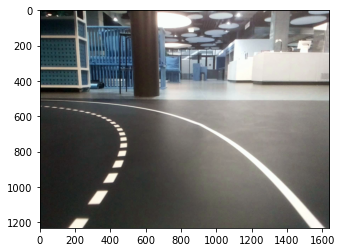

In [7]:
idx = random.randint(0, 2163)
print(idx)
idx=840
plt.imshow(col_images[idx])


# Processing for Image


In [8]:
def processImage(inpImage):

    # Apply HLS color filtering to filter out white lane lines
    hls = cv2.cvtColor(inpImage, cv2.COLOR_BGR2HLS)
    lower_white = np.array([180, 180, 180])
    upper_white = np.array([255, 255, 255])
    mask = cv2.inRange(inpImage, lower_white, upper_white)
    hls_result = cv2.bitwise_and(inpImage, inpImage, mask=mask)

    # Convert image to grayscale, apply threshold, blur & extract edges
    gray = cv2.cvtColor(hls_result, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(
        gray,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY_INV,
        21,
        4,
    )
    # ret, thresh = cv2.threshold(gray, 160, 255, cv2.THRESH_BINARY)
    blur = cv2.GaussianBlur(thresh, (7, 7), 0)
    canny = cv2.Canny(blur, 40, 60)

    # Display the processed images
    # plt.imshow("Image", inpImage)
    # plt.imshow("HLS Filtered", hls_result)
    # plt.imshow("Grayscale", gray)
    # plt.imshow("Thresholded", thresh)
    # plt.imshow("Blurred", blur)
    # plt.imshow("Canny Edges", canny)

    return hls_result, gray, thresh, blur, canny


In [9]:
imgtup=processImage(col_images[idx])

(1232, 1640)


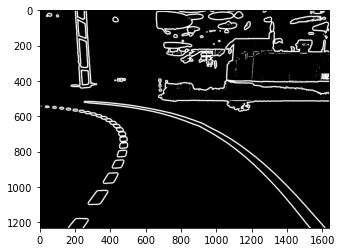

In [10]:
print(imgtup[2].shape)
plt.imshow(imgtup[2],cmap='gray')

(1232, 1640)


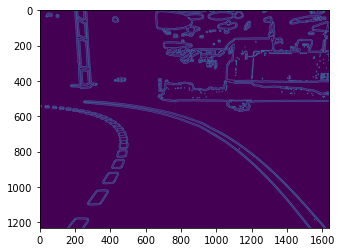

In [11]:
print(imgtup[4].shape)
plt.imshow(imgtup[4])


(1232, 1640)


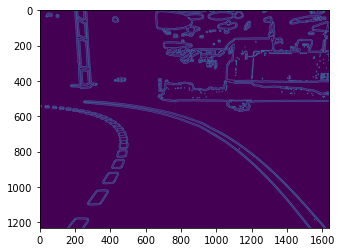

In [12]:
print(imgtup[4].shape)
plt.imshow(imgtup[4])

# How good is perspective wrapping ? 

- Instead of cropping the image using roi func we try to create a birds eye view for the image using perspective wrap for the roi
- The bird's eye view is finally plotted

Notes: Even though wrapping and operating on the image might change the turn angle in some way we can adjust for this using a PID controller on the steering

In [13]:
# roi = [[90, 500],       [800, 500],       [200, 1200],       [1600, 1200]]
def perspectiveWarp(inpImage,luroi=0.25,ruroi=0.75,lbroi=0,rbroi=1,hroi=0.55):

    roi = [
        (luroi*((inpImage.shape[1]-1)), hroi*(inpImage.shape[0]-1)),
        (ruroi*((inpImage.shape[1]-1)), hroi*(inpImage.shape[0]-1)),
        (lbroi*((inpImage.shape[1]-1)), inpImage.shape[0]-1),
        (rbroi*((inpImage.shape[1]-1)), inpImage.shape[0]-1),
    ]
    # roi = [[90, 500],       [800, 500],       [200, 1200],       [1600, 1200]]
    print(roi)
    # Get image size
    img_size = (inpImage.shape[1], inpImage.shape[0])

    # Perspective points to be warped
    
    src = np.float32(roi)

    # Window to be shown
    dst = np.float32([[0, 0],
                      [inpImage.shape[1], 0],
                      [0, inpImage.shape[0]],
                      [inpImage.shape[1], inpImage.shape[0]]])

    # Matrix to warp the image for birdseye window
    matrix = cv2.getPerspectiveTransform(src, dst)
    # Inverse matrix to unwarp the image for final window
    minv = cv2.getPerspectiveTransform(dst, src)
    birdseye = cv2.warpPerspective(inpImage, matrix, img_size)

    # Get the birdseye window dimensions
    height, width = birdseye.shape[:2]

    # Divide the birdseye view into 2 halves to separate left & right lanes
    birdseyeLeft = birdseye[0:height, 0:width // 2]
    birdseyeRight = birdseye[0:height, width // 2:width]

    # Display birdseye view image
    # cv2.imshow("Birdseye" , birdseye)
    # cv2.imshow("Birdseye Left" , birdseyeLeft)
    # cv2.imshow("Birdseye Right", birdseyeRight)

    return birdseye, birdseyeLeft, birdseyeRight, minv


In [14]:

perspec=perspectiveWarp(col_images[idx])

[(409.75, 677.0500000000001), (1229.25, 677.0500000000001), (0, 1231), (1639, 1231)]


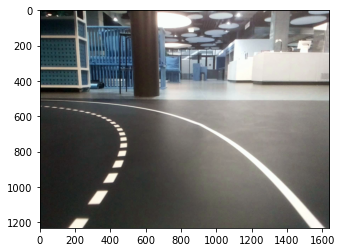

In [15]:
plt.imshow(col_images[idx])

(1232, 1640, 3)


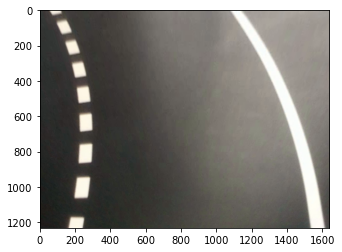

In [16]:
print(perspec[0].shape)
plt.imshow(perspec[0])


In [17]:
process=processImage(perspec[0])

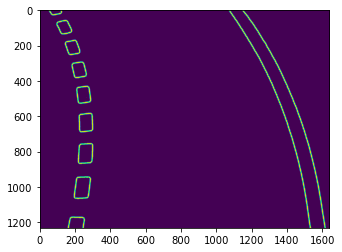

In [18]:
plt.imshow(process[2])

/tmp/ipykernel_6672/1180022040.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)


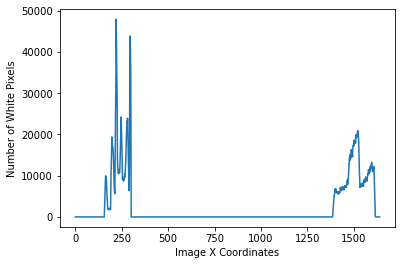

In [19]:
def plotHistogram(inpImage):

    histogram = np.sum(inpImage[inpImage.shape[0] // 2:, :], axis=0)

    midpoint = np.int(histogram.shape[0] / 2)
    leftxBase = np.argmax(histogram[:midpoint])
    rightxBase = np.argmax(histogram[midpoint:]) + midpoint

    plt.xlabel("Image X Coordinates")
    plt.ylabel("Number of White Pixels")

    # Return histogram and x-coordinates of left & right lanes to calculate
    # lane width in pixels
    return histogram, leftxBase, rightxBase


hist, leftBase, rightBase = plotHistogram(process[2])
# print(rightBase - leftBase)
plt.plot(hist)


In [20]:
def slide_window_search(binary_warped, histogram):

    # Find the start of left and right lane lines using histogram info
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    midpoint = np.int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # A total of 10 windows will be used
    nwindows = 10
    window_height = np.int(binary_warped.shape[0] / nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 150
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []

    #### START - Loop to iterate through windows and search for lane lines #####
    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high),
                      (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high),
                      (0, 255, 0), 2)
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
        # print(rightx_current)
    #### END - Loop to iterate through windows and search for lane lines #######

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    plt.xlim(0,out_img.shape[1])
    plt.ylim(0,out_img.shape[0])

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    # Apply 2nd degree polynomial fit to fit curves
    plt.gca().invert_yaxis()
    try:
        left_fit = np.polyfit(lefty, leftx, 1)
        left_fitx = left_fit[0] * ploty + left_fit[1] 
        plt.plot(left_fitx,  ploty, color='yellow')
    except:
        left_fit=[]
        left_fitx=[]
        # plt.plot(left_fitx,  ploty, color='yellow')
    try:
        right_fit = np.polyfit(righty, rightx,1)
        right_fitx = right_fit[0] * ploty + right_fit[1] 
        plt.plot(right_fitx, ploty, color='yellow')
    except:
        right_fit=[]
        right_fitx=[]
        # plt.plot(right_fitx, ploty, color='yellow')
    
    if left_fit == []:
        left_fit = right_fit
        left_fitx = right_fitx
    if right_fit == []:
        right_fit = left_fit
        right_fitx = left_fitx

    ltx = np.trunc(left_fitx)
    rtx = np.trunc(right_fitx)
    # plt.plot(right_fitx)
    # plt.show()

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # plt.imshow(out_img)
    


    return ploty, left_fit, right_fit, ltx, rtx, out_img


/tmp/ipykernel_6672/1610002819.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)
/tmp/ipykernel_6672/1610002819.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy

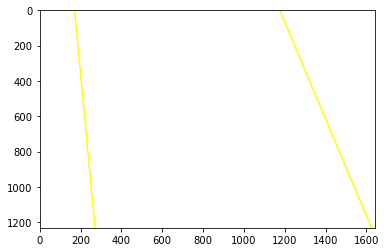

In [21]:
searchedplot = slide_window_search(process[2], hist)


[8.13303468e-02 1.70864579e+02] [3.64552771e-01 1.17629638e+03]


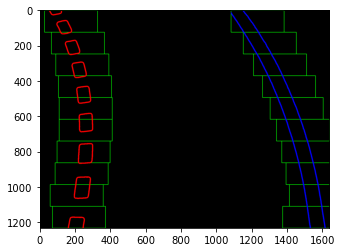

In [22]:
plt.imshow(searchedplot[5])
print(searchedplot[1],searchedplot[2])


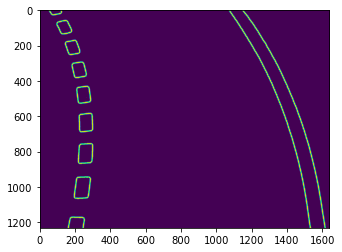

In [23]:
plt.imshow(process[2])

Slope of required line after coordinate system adjustment

In [26]:
print("Slope line L: ",-1/searchedplot[1][0],"\nSlope line R: ", -1/searchedplot[2][0])


Slope line L:  -12.295533447754716 
Slope line R:  -2.743087088490805
